In [3]:
import requests
import pandas as pd

In [4]:
url1 = "http://ec2-54-88-151-77.compute-1.amazonaws.com:3001/v1/admissions?limit=50000&offset=0"
conn1 = requests.get(url1).json()
file1 = conn1['admissions']
admissions =  pd.DataFrame.from_dict(file1, orient='columns')
admissions.head(1)

,admission_location,admission_type,admittime,deathtime,diagnosis,discharge_location,dischtime,edouttime,edregtime,ethnicity,hadm_id,has_chartevents_data,hospital_expire_flag,insurance,language,marital_status,religion,row_id,subject_id
0,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09T12:26:00.000Z,None,BENZODIAZEPINE OVERDOSE,DISC-TRAN CANCER/CHLDRN H,2196-04-10T15:54:00.000Z,2196-04-09T13:24:00.000Z,2196-04-09T10:06:00.000Z,WHITE,165315,1,0,Private,None,MARRIED,UNOBTAINABLE,21,22


In [5]:
admissions['diagnosis'].str.contains('HEART').value_counts()

False    48184
True      1795
Name: diagnosis, dtype: int64

In [6]:
'''Dropping rows not having heart failure'''
heartpatients = admissions[admissions['diagnosis'].str.contains('heart', case = False) & admissions['diagnosis'].notnull()]

In [7]:
url1 = "http://ec2-54-88-151-77.compute-1.amazonaws.com:3003/v1/conditions?limit=50000&offset=0"
conn1 = requests.get(url1).json()
file1 = conn1['conditions']
conditions =  pd.DataFrame.from_dict(file1, orient='columns')
conditions.head(1)

,downcase_name,id,index,name,nct_id
0,eosinophilic esophagitis,3620676,9263,Eosinophilic Esophagitis,NCT00275561


In [8]:
conditions['name'].str.contains('HEART', case=False).value_counts()

False    49325
True       675
Name: name, dtype: int64

In [9]:
#Dataframe with conditions of heart alone 652 rows
heartconditions = conditions[conditions['name'].str.contains('HEART', case=False) & conditions['name'].notnull()]
heartconditions.head(1)

,downcase_name,id,index,name,nct_id
49,heart diseases,3620724,9312,Heart Diseases,NCT00275145


In [10]:
url1 = "http://ec2-54-88-151-77.compute-1.amazonaws.com:3003/v1/eligibilities?limit=50000&offset=0"
conn1 = requests.get(url1).json()
file1 = conn1['eligibility']
eligibilities =  pd.DataFrame.from_dict(file1, orient='columns')
eligibilities.head(1)

,criteria,gender,gender_based,gender_description,healthy_volunteers,id,index,maximum_age,minimum_age,nct_id,population,sampling_method
0,\n Inclusion Criteria:\n\n - ...,All,None,,Accepts Healthy Volunteers,2130393,9829,N/A,60 Years,NCT01277809,,


In [11]:
eligibilities = eligibilities.drop(['gender_based','gender_description','id','index','criteria','healthy_volunteers'],axis=1)    

In [12]:
#missing : NONE
eligibilities.apply(lambda x: sum(x.isnull()))

gender             0
maximum_age        0
minimum_age        0
nct_id             0
population         0
sampling_method    0
dtype: int64

In [186]:
#eligibilities.sampling_method.unique()

In [188]:
#eligibilities.population.str.contains('').sum() # dropping this as well

In [13]:
eligibilities = eligibilities.drop(['population','sampling_method'],axis=1)

In [14]:
clinicaldf = pd.merge(eligibilities,heartconditions, on=['nct_id'], how = 'inner')

In [16]:
clinicaldf.head(1)

,gender,maximum_age,minimum_age,nct_id,downcase_name,id,index,name
0,All,N/A,18 Years,NCT01261065,heart failure,3502118,44839,Heart Failure


In [62]:
target = clinicaldf.drop(['downcase_name','id','index','name'],axis=1)

In [63]:

target.head(1)

,gender,maximum_age,minimum_age,nct_id
0,All,N/A,18 Years,NCT01261065


In [41]:
target.apply(lambda x: sum(x.isnull()))

gender         0
maximum_age    0
minimum_age    0
nct_id         0
dtype: int64

In [42]:
target.gender.value_counts()

All       65
Female     2
Male       2
Name: gender, dtype: int64

In [43]:
target.minimum_age.value_counts()

18 Years    51
N/A          5
20 Years     3
35 Years     2
30 Years     2
50 Years     1
40 Years     1
16 Years     1
6 Years      1
21 Years     1
25 Years     1
Name: minimum_age, dtype: int64

In [44]:
target.maximum_age.value_counts()

N/A         41
75 Years     5
70 Years     5
80 Years     4
65 Years     4
50 Years     2
85 Years     2
30 Days      1
95 Years     1
45 Years     1
59 Years     1
90 Years     1
18 Years     1
Name: maximum_age, dtype: int64

In [64]:
target[target.maximum_age=='30 Days']

,gender,maximum_age,minimum_age,nct_id
3,All,30 Days,N/A,NCT01215240


In [65]:
#replacing 30 Days with fraction of year = .08 Years (1 month)
target['maximum_age'] = target['maximum_age'].replace(['30 Days'], '0.08 Years')

'''Replacing N/A with 0 in minimum age'''
target['minimum_age'] = target['minimum_age'].replace(['N/A'], '0')

'''Replacing N/A with 150 in maximum age'''
target['maximum_age'] = target['maximum_age'].replace(['N/A'], '150 Years')

'''Split and Convert string to Float'''
target["minimum_age"] = target["minimum_age"].str.replace(" Years","").astype(float)

target["maximum_age"] = target["maximum_age"].str.replace(" Years","").astype(float)

In [66]:
target.maximum_age.value_counts()

150.00    41
70.00      5
75.00      5
65.00      4
80.00      4
85.00      2
50.00      2
95.00      1
0.08       1
45.00      1
59.00      1
18.00      1
90.00      1
Name: maximum_age, dtype: int64

In [54]:
heartpatients.head(1)

,admission_location,admission_type,admittime,deathtime,diagnosis,discharge_location,dischtime,edouttime,edregtime,ethnicity,hadm_id,has_chartevents_data,hospital_expire_flag,insurance,language,marital_status,religion,row_id,subject_id
18,EMERGENCY ROOM ADMIT,EMERGENCY,2183-08-21T16:48:00.000Z,None,CONGESTIVE HEART FAILURE,HOME HEALTH CARE,2183-08-26T18:54:00.000Z,2183-08-21T17:45:00.000Z,2183-08-21T05:58:00.000Z,WHITE,188670,1,0,Medicare,None,MARRIED,JEWISH,39,37


In [56]:
#Importing patients and combining with heartpatients of admissions
url = "http://ec2-54-88-151-77.compute-1.amazonaws.com:3001/v1/patients?limit=50000&offset=0"
conn = requests.get(url).json()
file = conn['patients']
patients =  pd.DataFrame.from_dict(file, orient='columns')

In [57]:
patientdf = pd.merge(patients,heartpatients, on=['subject_id'], how = 'inner')
#len(patientdf)

In [58]:
#Selecting columns
inpatient = patientdf[['subject_id','dob','dod','gender']].copy()
inpatient['gender'] = inpatient['gender'].replace(['M'], '1')
inpatient['gender'] = inpatient['gender'].replace(['F'], '0')
inpatient['gender'] = inpatient.gender.astype(int)
inpatient['dod'] = inpatient.dod.fillna('')
inpatient['dod'] = inpatient['dod'].replace('', '2168-10-28 00:00:00')
inpatient['dob'] = pd.to_datetime(inpatient['dob'])
inpatient['dod'] = pd.to_datetime(inpatient['dod'])
inpatient['age'] = inpatient['dod'] - inpatient['dob']
inpatient['age'] = inpatient.age.dt.days
inpatient['age'] = inpatient['age']/365
inpatient = inpatient.drop(['dob','dod'],axis = 1)

#Dropping rows whose age is neagtive and whose age is above 150
inpatient = inpatient.drop(inpatient[inpatient.age < 0].index)
inpatient = inpatient.drop(inpatient[inpatient.age > 130].index)

inpatient.head(1)

,subject_id,gender,age
0,253,0,78.972603


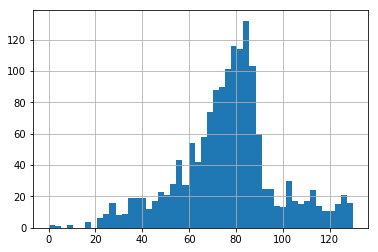

In [59]:
%matplotlib inline
inpatient.age.hist(bins = 50)

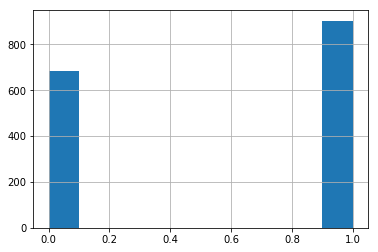

In [60]:
inpatient.gender.hist()

In [67]:
#Replacing male with 1 in target| Replacing female with 1 in target| Replacing ALL with 2 in target
target['gender'] = target['gender'].replace(['Male'], '1')
target['gender'] = target['gender'].replace(['Female'], '0')
target['gender'] = target['gender'].replace(['All'], '2')
target.maximum_age = target.maximum_age.astype(float)
target.minimum_age = target.minimum_age.astype(float)
target.gender = target.gender.astype(int)

In [68]:
target.gender.value_counts()

2    65
1     2
0     2
Name: gender, dtype: int64

In [72]:
#Selecting that specific study needing a female patient
#target[target.gender == 0]

In [783]:
#adding a study NCTID to inpatient
#inpatient['NCT00007358'] = ''

In [741]:
#Checking eligibility for study NCT00007358
def eligible(gender,age):
    if gender == 0:
        if age >=16 and age <=50:
            return 1
        else:
            return 0
    else:
        return 0

In [73]:
target = (target.drop_duplicates())

In [74]:
target[target['gender']==0]

,gender,maximum_age,minimum_age,nct_id
58,0,45.0,25.0,NCT00760253
59,0,50.0,18.0,NCT00759733


In [788]:
#for index, row in inpatient.iterrows():
#    (inpatient['NCT00007358'].iloc[index]) = eligible((inpatient['gender'].iloc[index]),(inpatient['age'].iloc[index]))
#    print(inpatient['NCT00007358'].iloc[index])

#Applying lambda to generate eligibility of a study
inpatient['NCT00007358'] = inpatient.apply(lambda x: eligible(x['gender'], x['age']), axis=1)

In [791]:
womenheartstudy = inpatient[inpatient['NCT00007358']==1]

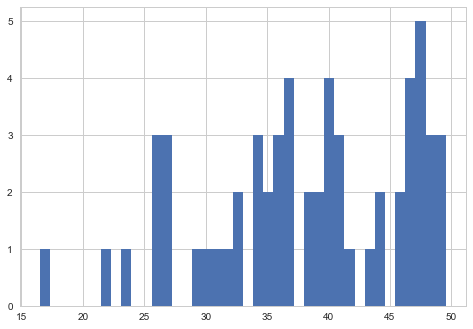

In [870]:
womenheartstudy['age'].hist(bins=40)

In [848]:
for x in target:
   print(x)
#target['nct_id'][2]

gender
maximum_age
minimum_age
nct_id


In [855]:
inpatient = inpatient.drop(['NCT00382525','NCT00542854'],axis=1)

In [857]:
#Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


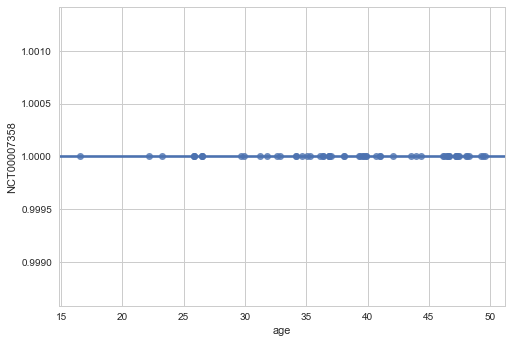

In [864]:
sns.regplot(womenheartstudy['age'],womenheartstudy['NCT00007358'])

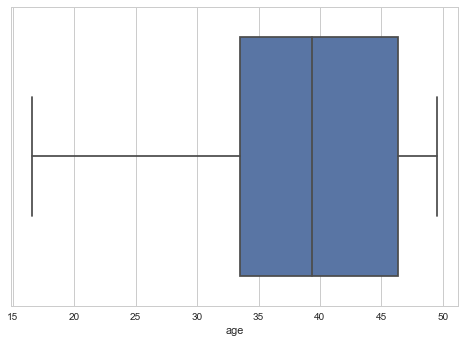

In [874]:
sns.boxplot(womenheartstudy['age'])

In [77]:
inpatient=inpatient.reset_index(drop=True)

In [80]:
for x in range(0,inpatient.shape[0]):
    for j in range(0,target.shape[0]):
        if (target.loc[j,'gender']==2) & (target.loc[j,'minimum_age']<=inpatient.loc[x,'age']<=target.loc[j,'maximum_age']):
            inpatient.loc[x,target.loc[j,'nct_id']]=1
        elif (target.loc[j,'gender']==inpatient.loc[x,'gender']) & (target.loc[j,'minimum_age']<=inpatient.loc[x,'age']<=target.loc[j,'maximum_age']):
            inpatient.loc[x,target.loc[j,'nct_id']]=1 
 


In [81]:
inpatient.head(5)

,subject_id,gender,age,NCT01261065,NCT01252030,NCT01242722,NCT01211886,NCT01171625,NCT01166360,NCT01130597,...,NCT00960505,NCT00858845,NCT00804882,NCT00776035,NCT00713635,NCT00973986,NCT00759733,NCT00760253,NCT00829842,NCT01215240
0,253,0,78.972603,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,665,1,67.753425,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,702,1,26.293151,1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,704,1,84.698630,1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,711,1,85.279452,1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
target.head()

,gender,maximum_age,minimum_age,nct_id
0,2,150.00,18.0,NCT01261065
1,2,80.00,40.0,NCT01252030
2,2,150.00,18.0,NCT01242722
3,2,0.08,0.0,NCT01215240
4,2,150.00,18.0,NCT01211886


In [84]:
target[target.gender==0]

,gender,maximum_age,minimum_age,nct_id
58,0,45.0,25.0,NCT00760253
59,0,50.0,18.0,NCT00759733


In [95]:
target[target.gender==1]

,gender,maximum_age,minimum_age,nct_id
19,1,65.0,35.0,NCT00973986
51,1,70.0,18.0,NCT00795405


In [99]:
#inpatient.drop_duplicates()

In [100]:
inpatient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1585 entries, 0 to 1584
Data columns (total 72 columns):
subject_id     1585 non-null int64
gender         1585 non-null int32
age            1585 non-null float64
NCT01261065    1577 non-null float64
NCT01252030    778 non-null float64
NCT01242722    1577 non-null float64
NCT01211886    1577 non-null float64
NCT01171625    1577 non-null float64
NCT01166360    1577 non-null float64
NCT01130597    1577 non-null float64
NCT01125436    1412 non-null float64
NCT01105923    1577 non-null float64
NCT01091467    1577 non-null float64
NCT01077167    1577 non-null float64
NCT01071772    837 non-null float64
NCT00764075    1577 non-null float64
NCT01002456    1585 non-null float64
NCT00983190    1577 non-null float64
NCT00981253    1520 non-null float64
NCT00893178    1577 non-null float64
NCT00911703    1577 non-null float64
NCT00907764    1577 non-null float64
NCT00843245    1577 non-null float64
NCT00881439    1577 non-null float64
NCT00867984

In [102]:
inpatient[inpatient.NCT00829842==1.0]

,subject_id,gender,age,NCT01261065,NCT01252030,NCT01242722,NCT01211886,NCT01171625,NCT01166360,NCT01130597,...,NCT00960505,NCT00858845,NCT00804882,NCT00776035,NCT00713635,NCT00973986,NCT00759733,NCT00760253,NCT00829842,NCT01215240
170,5296,0,16.523288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
723,15617,0,4.380822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
927,26790,1,9.449315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
971,26188,0,8.484932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
1270,15789,1,17.739726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
1522,72781,1,17.295890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
1547,65449,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0
1548,65449,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0


In [103]:
target[target.nct_id == 'NCT00829842']

,gender,maximum_age,minimum_age,nct_id
45,2,18.0,0.0,NCT00829842


In [108]:
inpatient['NCT00829842'].count()

8